ECON5140. Homework 1. Part 2. Artykzhan Ospan

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

In [9]:
# DATASET 1: Customer Purchase Behavior
n_customers = 1000

age = np.random.normal(35, 10, n_customers)
income = np.random.normal(50, 15, n_customers)          # thousands
time_on_site = np.random.gamma(2, 3, n_customers)       # minutes

z = -3 + 0.05 * age + 0.04 * income + 0.15 * time_on_site + np.random.normal(0, 1, n_customers)
purchase = (z > 0).astype(int)

df_customers = pd.DataFrame({
    "Age": age,
    "Income": income,
    "TimeOnSite": time_on_site,
    "Purchase": purchase
})

print("Customer data:")
print("n =", len(df_customers))
print("purchase rate =", f"{df_customers['Purchase'].mean():.2%}")
print(df_customers.head())

Customer data:
n = 1000
purchase rate = 90.00%
         Age     Income  TimeOnSite  Purchase
0  39.967142  70.990332    2.814421         1
1  33.617357  63.869505    4.460907         1
2  41.476885  50.894456    0.667441         1
3  50.230299  40.295948    5.872412         1
4  32.658466  60.473350    8.012511         1


In [11]:
# DATASET 2: E-commerce Daily Sales
dates = pd.date_range("2024-01-01", "2025-12-31", freq="D")
n_days = len(dates)
t = np.arange(n_days)

trend = 1000 + 2 * t + 0.01 * t**2
yearly = 200 * np.sin(2 * np.pi * t / 365) + 150 * np.cos(2 * np.pi * t / 365)
weekly = 100 * np.sin(2 * np.pi * t / 7)

special = np.zeros(n_days)
for year in [2024, 2025]:
    bf_date = pd.Timestamp(f"{year}-11-24")
    xmas_date = pd.Timestamp(f"{year}-12-25")
    special[dates == bf_date] = 800
    special[dates == xmas_date] = 400

noise = np.random.normal(0, 50, n_days)

sales = trend + yearly + weekly + special + noise
sales = np.maximum(sales, 0)

df_sales = pd.DataFrame({
    "Date": dates,
    "Sales": sales,
    "DayOfWeek": dates.dayofweek,
    "Month": dates.month,
    "IsWeekend": (dates.dayofweek >= 5)
}).set_index("Date")

print("\nSales data:")
print("date range:", df_sales.index.min().date(), "to", df_sales.index.max().date())
print("n =", len(df_sales))
print(df_sales["Sales"].describe())

# New customers (given)
new_customers = pd.DataFrame({
    "Age": [25, 35, 45, 55],
    "Income": [30, 50, 70, 90],
    "TimeOnSite": [2, 5, 8, 10]
})


Sales data:
date range: 2024-01-01 to 2025-12-31
n = 731
count     731.000000
mean     3507.603133
std      1965.720915
min      1061.751531
25%      1586.286522
50%      3231.471628
75%      4941.486536
max      8342.638282
Name: Sales, dtype: float64


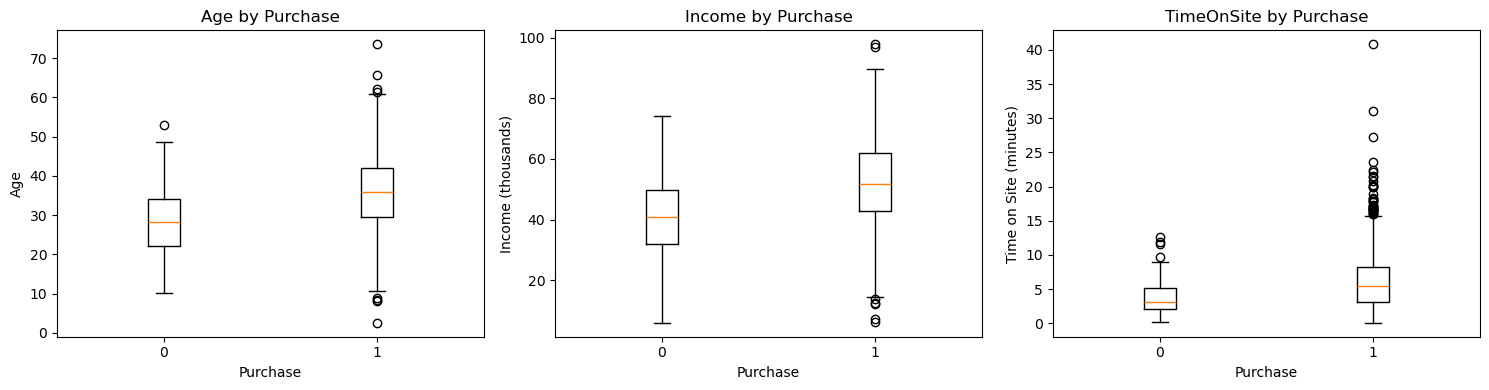


Means by Purchase:
                Age     Income  TimeOnSite
Purchase                                  
0         28.673571  40.152509    3.925442
1         35.917737  52.274770    6.340959

Correlation matrix:
                 Age    Income  TimeOnSite
Age         1.000000 -0.040400    0.004522
Income     -0.040400  1.000000   -0.045958
TimeOnSite  0.004522 -0.045958    1.000000


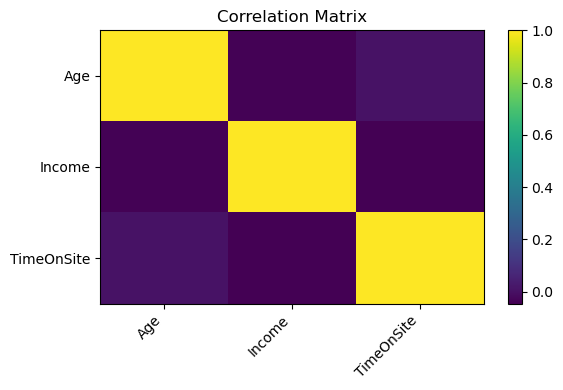

In [13]:
# A1: EDA
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

g0 = df_customers[df_customers["Purchase"] == 0]
g1 = df_customers[df_customers["Purchase"] == 1]

axes[0].boxplot([g0["Age"], g1["Age"]], labels=["0", "1"])
axes[0].set_title("Age by Purchase")
axes[0].set_xlabel("Purchase")
axes[0].set_ylabel("Age")

axes[1].boxplot([g0["Income"], g1["Income"]], labels=["0", "1"])
axes[1].set_title("Income by Purchase")
axes[1].set_xlabel("Purchase")
axes[1].set_ylabel("Income (thousands)")

axes[2].boxplot([g0["TimeOnSite"], g1["TimeOnSite"]], labels=["0", "1"])
axes[2].set_title("TimeOnSite by Purchase")
axes[2].set_xlabel("Purchase")
axes[2].set_ylabel("Time on Site (minutes)")

plt.tight_layout()
plt.show()

means = df_customers.groupby("Purchase")[["Age", "Income", "TimeOnSite"]].mean()
print("\nMeans by Purchase:")
print(means)

corr = df_customers[["Age", "Income", "TimeOnSite"]].corr()
print("\nCorrelation matrix:")
print(corr)

plt.figure(figsize=(6, 4))
plt.imshow(corr.values, aspect="auto")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar()
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


LPM results:
                            OLS Regression Results                            
Dep. Variable:               Purchase   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     55.67
Date:                Thu, 29 Jan 2026   Prob (F-statistic):           2.86e-33
Time:                        13:22:55   Log-Likelihood:                -137.46
No. Observations:                1000   AIC:                             282.9
Df Residuals:                     996   BIC:                             302.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3104      0.047      

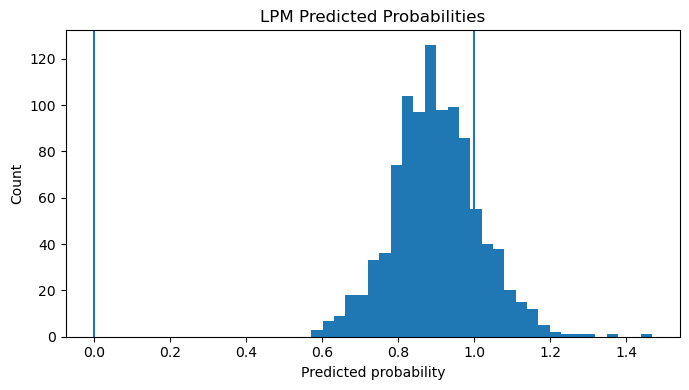

In [15]:
# A2: Linear Probability Model
X = sm.add_constant(df_customers[["Age", "Income", "TimeOnSite"]])
y = df_customers["Purchase"]

lpm = sm.OLS(y, X).fit()
print("\nLPM results:")
print(lpm.summary())

p_lpm = lpm.predict(X)
invalid_pct = ((p_lpm < 0) | (p_lpm > 1)).mean() * 100
print(f"\nLPM predictions outside [0,1]: {invalid_pct:.2f}%")

plt.figure(figsize=(7, 4))
plt.hist(p_lpm, bins=30)
plt.axvline(0)
plt.axvline(1)
plt.title("LPM Predicted Probabilities")
plt.xlabel("Predicted probability")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Optimization terminated successfully.
         Current function value: 0.238157
         Iterations 8

Logit results:
                           Logit Regression Results                           
Dep. Variable:               Purchase   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      996
Method:                           MLE   Df Model:                            3
Date:                Thu, 29 Jan 2026   Pseudo R-squ.:                  0.2674
Time:                        13:23:08   Log-Likelihood:                -238.16
converged:                       True   LL-Null:                       -325.08
Covariance Type:            nonrobust   LLR p-value:                 1.874e-37
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.8737      0.715     -8.213      0.000      -7.275      -4.472
Age          

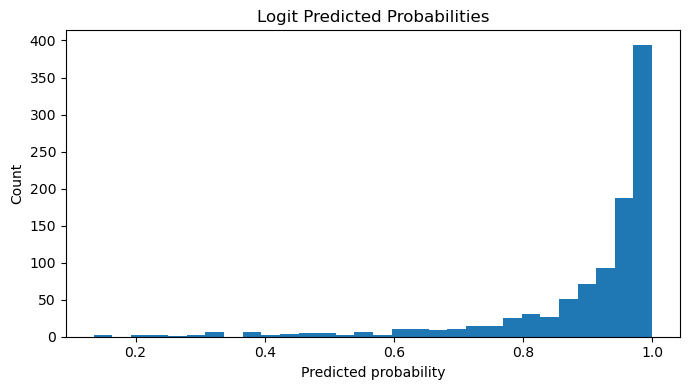

In [17]:
# A3: Logistic Regression
logit_model = sm.Logit(y, X).fit()
print("\nLogit results:")
print(logit_model.summary())

coef = logit_model.params
odds = np.exp(coef)
pvals = logit_model.pvalues

print("\nCoefficients:")
print(coef)
print("\nOdds ratios:")
print(odds)
print("\nP-values:")
print(pvals)

p_logit = logit_model.predict(X)
plt.figure(figsize=(7, 4))
plt.hist(p_logit, bins=30)
plt.title("Logit Predicted Probabilities")
plt.xlabel("Predicted probability")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [19]:
# A4: Predictions for New Customers
X_new = sm.add_constant(new_customers, has_constant="add")
p_new = logit_model.predict(X_new)

pred_table = new_customers.copy()
pred_table["PredictedProb"] = p_new
pred_table["Classification"] = (pred_table["PredictedProb"] > 0.5).astype(int)

print("\nNew customer predictions:")
print(pred_table)

best_idx = pred_table["PredictedProb"].idxmax()
print(f"\nMost likely to purchase: row {best_idx} (p={pred_table.loc[best_idx,'PredictedProb']:.3f})")


New customer predictions:
   Age  Income  TimeOnSite  PredictedProb  Classification
0   25      30           2       0.371500               0
1   35      50           5       0.942887               1
2   45      70           8       0.997836               1
3   55      90          10       0.999898               1

Most likely to purchase: row 3 (p=1.000)


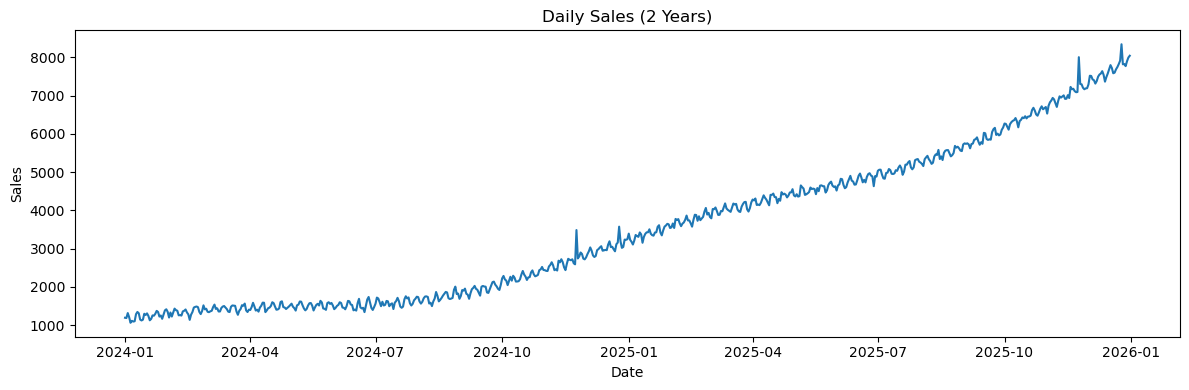

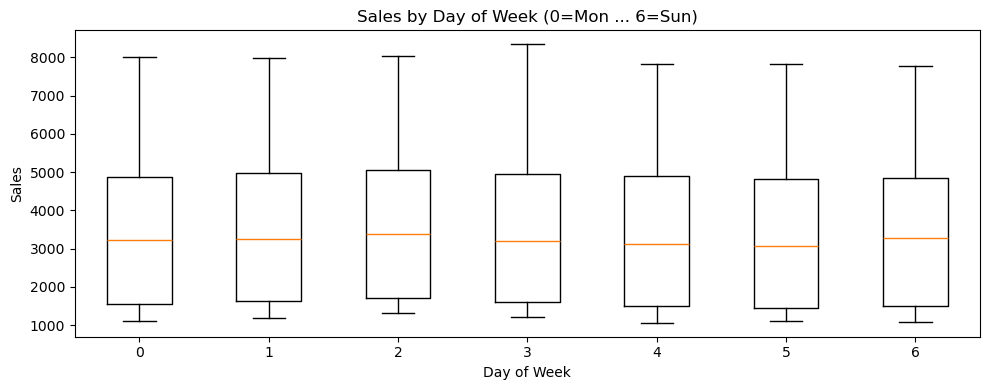

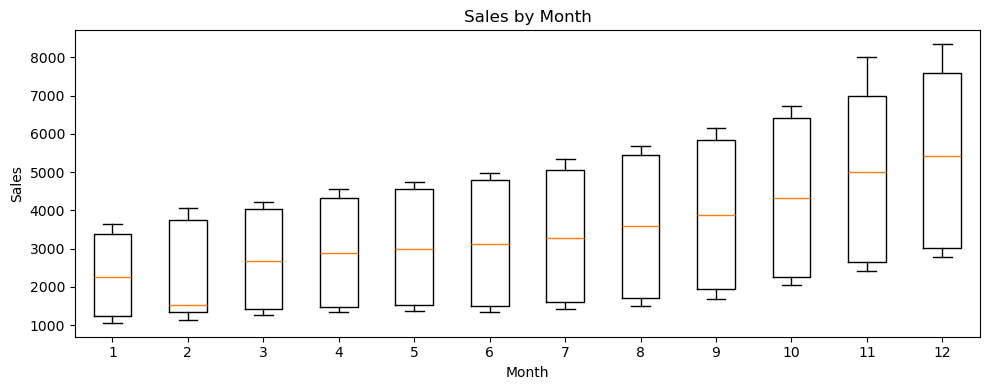


Mean sales by day of week:
DayOfWeek
0    3511.596906
1    3581.433349
2    3623.584906
3    3535.594781
4    3449.357961
5    3404.723571
6    3445.066938
Name: Sales, dtype: float64

Mean sales by month:
Month
1     2318.589573
2     2534.425148
3     2732.951942
4     2901.430048
5     3027.989448
6     3144.380483
7     3342.999798
8     3581.537558
9     3908.669782
10    4358.309037
11    4843.072951
12    5343.146204
Name: Sales, dtype: float64


In [21]:
# B1: Time series plots
plt.figure(figsize=(12, 4))
plt.plot(df_sales.index, df_sales["Sales"])
plt.title("Daily Sales (2 Years)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

dow_data = [df_sales.loc[df_sales["DayOfWeek"] == d, "Sales"].values for d in range(7)]
plt.figure(figsize=(10, 4))
plt.boxplot(dow_data, labels=list(range(7)))
plt.title("Sales by Day of Week (0=Mon ... 6=Sun)")
plt.xlabel("Day of Week")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

month_data = [df_sales.loc[df_sales["Month"] == m, "Sales"].values for m in range(1, 13)]
plt.figure(figsize=(10, 4))
plt.boxplot(month_data, labels=list(range(1, 13)))
plt.title("Sales by Month")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

print("\nMean sales by day of week:")
print(df_sales.groupby("DayOfWeek")["Sales"].mean())

print("\nMean sales by month:")
print(df_sales.groupby("Month")["Sales"].mean())

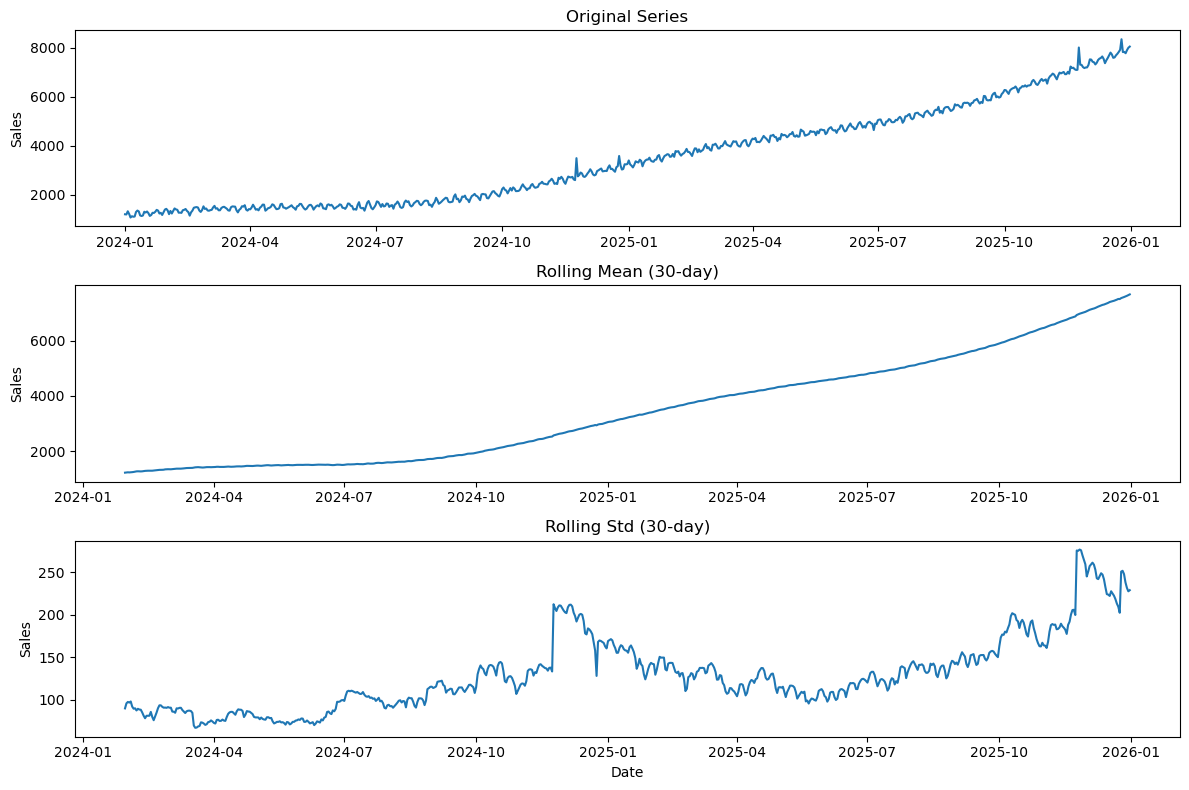


First 6 months mean/std:
1417.7217886495957 131.02707195516896
Last 6 months mean/std:
6254.4148334291185 916.379312804585


In [23]:
# B2: Rolling mean/std + first vs last 6 months
roll_mean = df_sales["Sales"].rolling(30).mean()
roll_std = df_sales["Sales"].rolling(30).std()

fig, axes = plt.subplots(3, 1, figsize=(12, 8))
axes[0].plot(df_sales.index, df_sales["Sales"])
axes[0].set_title("Original Series")
axes[0].set_ylabel("Sales")

axes[1].plot(df_sales.index, roll_mean)
axes[1].set_title("Rolling Mean (30-day)")
axes[1].set_ylabel("Sales")

axes[2].plot(df_sales.index, roll_std)
axes[2].set_title("Rolling Std (30-day)")
axes[2].set_ylabel("Sales")
axes[2].set_xlabel("Date")

plt.tight_layout()
plt.show()

start = df_sales.index.min()
end = df_sales.index.max()
first_6_end = start + pd.DateOffset(months=6)
last_6_start = end - pd.DateOffset(months=6)

first6 = df_sales.loc[(df_sales.index >= start) & (df_sales.index < first_6_end), "Sales"]
last6 = df_sales.loc[(df_sales.index > last_6_start) & (df_sales.index <= end), "Sales"]

print("\nFirst 6 months mean/std:")
print(first6.mean(), first6.std())
print("Last 6 months mean/std:")
print(last6.mean(), last6.std())

<Figure size 1000x400 with 0 Axes>

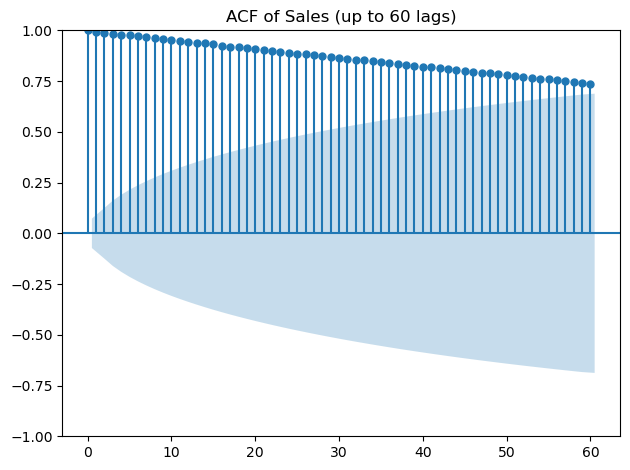


Manual autocorrelations:
Lag 1:  0.9983
Lag 7:  0.9987
Lag 30: 0.9957


In [25]:
# B3: ACF + manual correlations
plt.figure(figsize=(10, 4))
plot_acf(df_sales["Sales"], lags=60)
plt.title("ACF of Sales (up to 60 lags)")
plt.tight_layout()
plt.show()

sales_arr = df_sales["Sales"].values

def corr_lag(arr, lag):
    return np.corrcoef(arr[:-lag], arr[lag:])[0, 1]

lag1 = corr_lag(sales_arr, 1)
lag7 = corr_lag(sales_arr, 7)
lag30 = corr_lag(sales_arr, 30)

print("\nManual autocorrelations:")
print(f"Lag 1:  {lag1:.4f}")
print(f"Lag 7:  {lag7:.4f}")
print(f"Lag 30: {lag30:.4f}")

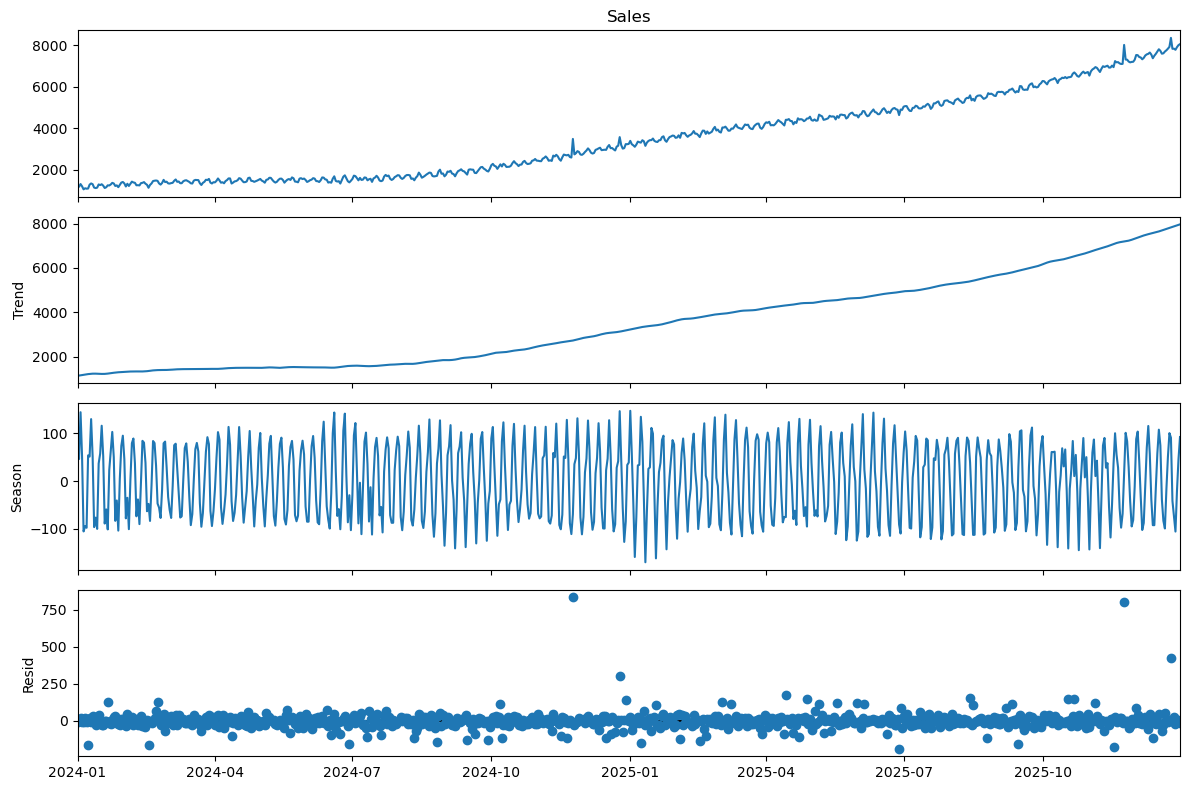

In [31]:
# B4: STL decomposition (weekly)
stl = STL(df_sales["Sales"], seasonal=7, robust=True)
res = stl.fit()

fig = res.plot()
fig.set_size_inches(12, 8)
plt.tight_layout()
plt.show()

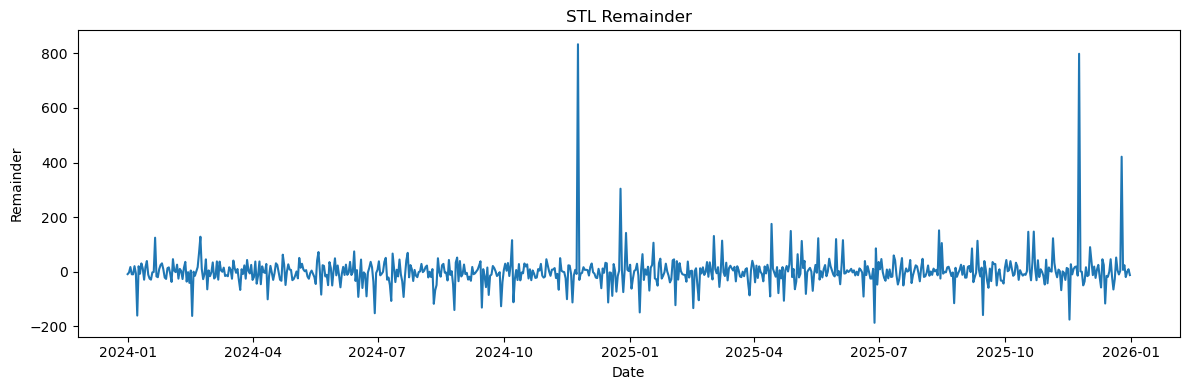

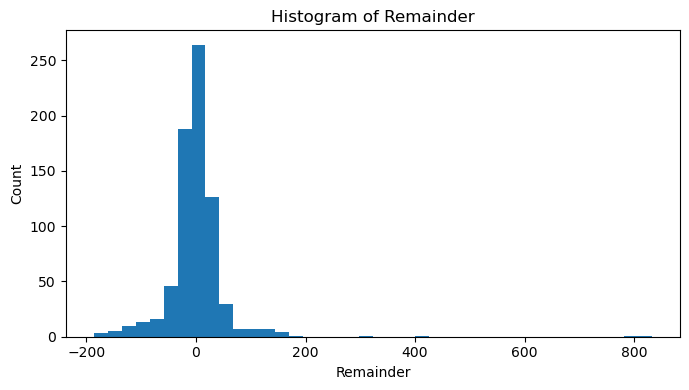

<Figure size 1000x400 with 0 Axes>

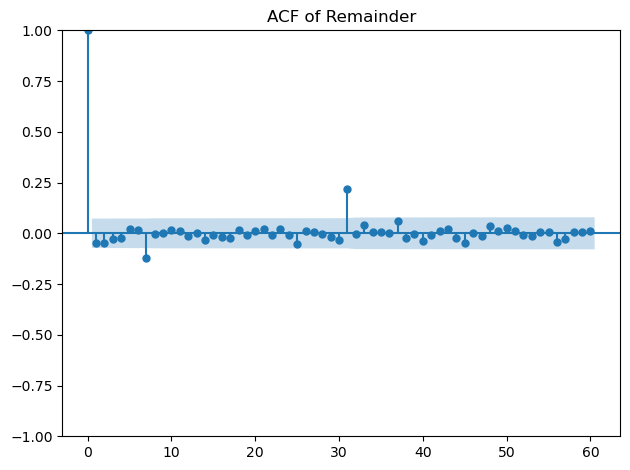


Remainder mean: 1.4664
Remainder std:  62.7940

Jarque-Bera stat: 197768.3137
JB p-value:       0.000000
Skew:             6.4033
Kurtosis:         82.5555

Outliers where |remainder| > 3*std (count=4):
Date
2024-11-24    832.829579
2025-11-24    798.030117
2025-12-25    421.273103
2024-12-25    304.194991
Name: resid, dtype: float64
2024 Black Friday remainder: 832.8295794097007
2024 Christmas remainder: 304.19499118562817
2025 Black Friday remainder: 798.0301173109438
2025 Christmas remainder: 421.27310256981946


In [33]:
# B5: Remainder diagnostics + outliers
remainder = res.resid

plt.figure(figsize=(12, 4))
plt.plot(remainder.index, remainder.values)
plt.title("STL Remainder")
plt.xlabel("Date")
plt.ylabel("Remainder")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.hist(remainder.values, bins=40)
plt.title("Histogram of Remainder")
plt.xlabel("Remainder")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plot_acf(remainder.dropna(), lags=60)
plt.title("ACF of Remainder")
plt.tight_layout()
plt.show()

rem_mean = remainder.mean()
rem_std = remainder.std()
print(f"\nRemainder mean: {rem_mean:.4f}")
print(f"Remainder std:  {rem_std:.4f}")

jb_stat, jb_pvalue, skew, kurt = sm.stats.jarque_bera(remainder.dropna())
print(f"\nJarque-Bera stat: {jb_stat:.4f}")
print(f"JB p-value:       {jb_pvalue:.6f}")
print(f"Skew:             {skew:.4f}")
print(f"Kurtosis:         {kurt:.4f}")

outlier_mask = remainder.abs() > 3 * rem_std
outliers = remainder[outlier_mask].sort_values(key=lambda s: s.abs(), ascending=False)

print(f"\nOutliers where |remainder| > 3*std (count={outliers.shape[0]}):")
print(outliers.head(25))

for year in [2024, 2025]:
    bf_date = pd.Timestamp(f"{year}-11-24")
    xmas_date = pd.Timestamp(f"{year}-12-25")
    if bf_date in remainder.index:
        print(f"{year} Black Friday remainder:", float(remainder.loc[bf_date]))
    if xmas_date in remainder.index:
        print(f"{year} Christmas remainder:", float(remainder.loc[xmas_date]))